# FinBERT Profiling: Baseline vs FP16 vs AMP

This notebook is intentionally **thin**: it reuses the profiling utilities in `pipelines/finBERT/finbert/` (especially `finbert/finbert_profile.py` and `finbert/profile_utils.py`) instead of copying large code blocks.

### What this notebook compares
- **Training**: Baseline (FP32) vs **AMP** (autocast + GradScaler) — wall time + profiler breakdown + accuracy
- **Inference** (from the **baseline checkpoint**): FP32 vs **FP16-weights** vs **AMP-autocast** — throughput/latency + accuracy



## Quick start

1. Run **Setup + Config + Helpers** (cells 2–4).
2. Run **Training** (cell 5) to train/eval **baseline** and **AMP**.
3. Run **Inference benchmarking** (cell 6) to benchmark **baseline / FP16-weights / AMP-autocast** off the baseline checkpoint.
4. Run **Results** (cell 7) to see comparison tables and plots.

### Notes
- **AMP and FP16 are only enabled on CUDA by default** (to avoid MPS/CPU autocast edge cases).
- If you already have a trained checkpoint you want to use, set `BASELINE_CKPT_DIR` in the config cell and set `RUN_TRAIN_BASELINE = False`.
- This notebook follows the same “thin notebook, modules do the work” style as `finbert_sweep.ipynb`.



In [1]:
from __future__ import annotations

from pathlib import Path
import sys
import time
import warnings

import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification

# Silence noisy deprecations (we still keep runtime-correct code)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="`torch\\.cuda\\.amp\\.autocast\\(args\\.\\.\\.\\)` is deprecated",
)


def _find_finbert_root(start: Path) -> Path:
    """Return the directory that contains the `finbert/` package."""
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "finbert").is_dir() and (p / "finbert" / "finbert.py").exists():
            return p
        if (p / "pipelines" / "finBERT" / "finbert").is_dir():
            return p / "pipelines" / "finBERT"
    raise FileNotFoundError(
        "Could not locate finBERT root. Expected a folder containing finbert/finbert.py"
    )


FINBERT_ROOT = _find_finbert_root(Path.cwd())
if str(FINBERT_ROOT) not in sys.path:
    sys.path.insert(0, str(FINBERT_ROOT))

PROJECT_ROOT = FINBERT_ROOT.parents[1] if FINBERT_ROOT.name == "finBERT" else FINBERT_ROOT.parent

from finbert.finbert import Config, FinBert
from finbert.finbert_profile import ProfiledFinBert, profile_inference
from finbert.profile_utils import get_model_size_mb, print_device_info, setup_nltk_data
from finbert.utils import get_device

LABEL_LIST = ["positive", "negative", "neutral"]

pd.set_option("display.max_colwidth", 120)

print("✓ FINBERT_ROOT:", FINBERT_ROOT)
print("✓ PROJECT_ROOT:", PROJECT_ROOT)
print("✓ torch:", torch.__version__)
print("✓ cuda available:", torch.cuda.is_available())
print("✓ mps available:", hasattr(torch.backends, "mps") and torch.backends.mps.is_available())



✓ Helper utilities loaded
✓ FINBERT_ROOT: /home/srm2245/hpml-project/pipelines/finBERT
✓ PROJECT_ROOT: /home/srm2245/hpml-project
✓ torch: 2.9.1+cu128
✓ cuda available: True
✓ mps available: False


In [2]:
# =========================
# Experiment configuration
# =========================

BASE_MODEL_NAME = "bert-base-uncased"

DATA_DIR = FINBERT_ROOT / "data" / "sentiment_data"

# Where to write new trained models (kept separate from the shipped `models/sentiment` checkpoint)
RUNS_DIR = FINBERT_ROOT / "models" / "profiling_runs"
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# If you want to skip training, point this at an existing checkpoint directory
BASELINE_CKPT_DIR = FINBERT_ROOT / "models" / "sentiment"

# Training params (using optimal hyperparameters from W&B sweep: solar-sweep-21)
TRAINING = dict(
    num_train_epochs=6,
    train_batch_size=32,
    eval_batch_size=32,
    learning_rate=1.4e-5,
    warm_up_proportion=0.144,
    max_seq_length=64,
    discriminate=False,
    gradual_unfreeze=False,
)

# Profiling params
PROFILE_TRAIN_STEPS = 20  # first N optimizer steps to profile during training

INFER_TEXT_BATCH_SIZE = 5
INFER_TEST_TEXT = """Later that day Apple said it was revising down its earnings expectations in \
The fourth quarter of 2018, largely because of lower sales and signs of economic weakness in China. \
The news rapidly infected financial markets. Apple's share price fell by around 7% in after-hours \
Trading and the decline was extended to more than 10% when the market opened. The dollar fell \
By 3.7% against the yen in a matter of minutes after the announcement, before rapidly recovering \
Some ground. Asian stockmarkets closed down on January 3rd and European ones opened lower. \
Yields on government bonds fell as investors fled to the traditional haven in a market storm."""

# Device settings
PREFER_GPU = True
GPU_NAME = "cuda:0"  # only used when CUDA is present

# Optional W&B logging (same idea as `finbert_sweep.ipynb`)
USE_WANDB = False
WANDB_ENTITY = "si2449-columbia-university"
WANDB_PROJECT = "finbert-profiling"
WANDB_GROUP = "profiling"

# Which runs to execute
RUN_TRAIN_BASELINE = True
RUN_TRAIN_AMP = True
RUN_INFER_BENCHMARKS = True

# Safety
OVERWRITE_EXISTING_RUN_DIRS = True

# Variants (edit here to add/remove)
INFERENCE_VARIANTS = {
    "baseline": {"torch_dtype": None, "use_amp": False, "requires_cuda": False},
    "fp16_weights": {"torch_dtype": torch.float16, "use_amp": False, "requires_cuda": True},
    "amp_autocast": {"torch_dtype": None, "use_amp": True, "requires_cuda": True},
}

print("✓ DATA_DIR:", DATA_DIR)
print("✓ RUNS_DIR:", RUNS_DIR)
print("✓ BASELINE_CKPT_DIR:", BASELINE_CKPT_DIR)
print("✓ INFERENCE_VARIANTS:", list(INFERENCE_VARIANTS.keys()))



✓ DATA_DIR: /home/srm2245/hpml-project/pipelines/finBERT/data/sentiment_data
✓ RUNS_DIR: /home/srm2245/hpml-project/pipelines/finBERT/models/profiling_runs
✓ BASELINE_CKPT_DIR: /home/srm2245/hpml-project/pipelines/finBERT/models/sentiment
✓ INFERENCE_VARIANTS: ['baseline', 'fp16_weights', 'amp_autocast']


In [4]:
from __future__ import annotations

from contextlib import nullcontext
from typing import Any

import torch.nn.functional as F
from sklearn.metrics import f1_score


def resolve_device(prefer_gpu: bool = True, gpu_name: str = "cuda:0") -> torch.device:
    if not prefer_gpu:
        return torch.device("cpu")

    device = get_device(no_cuda=False)
    if device.type == "cuda" and gpu_name.startswith("cuda:"):
        return torch.device(gpu_name)
    return device


def autocast_ctx(device: torch.device, enabled: bool):
    if not enabled:
        return nullcontext()
    if device.type != "cuda":
        # Keep this conservative: AMP is only enabled on CUDA in this notebook.
        return nullcontext()
    try:
        return torch.amp.autocast(device_type="cuda", enabled=True)
    except Exception:
        # Older torch fallback
        return torch.cuda.amp.autocast(enabled=True)


def make_run_dir(prefix: str) -> Path:
    ts = time.strftime("%Y%m%d_%H%M%S")
    run_dir = RUNS_DIR / f"{prefix}_{ts}"

    if run_dir.exists() and OVERWRITE_EXISTING_RUN_DIRS:
        import shutil

        shutil.rmtree(run_dir)

    if run_dir.exists() and any(run_dir.iterdir()):
        raise ValueError(f"Run dir exists and is not empty: {run_dir}")

    return run_dir


def make_finbert_config(*, model_dir: Path, use_amp: bool) -> Config:
    # Guard AMP to CUDA only (FinBERT training uses torch.cuda.amp.*)
    use_amp = bool(use_amp and torch.cuda.is_available())

    bertmodel = AutoModelForSequenceClassification.from_pretrained(
        BASE_MODEL_NAME, cache_dir=None, num_labels=3
    )

    cfg = Config(
        data_dir=DATA_DIR,
        bert_model=bertmodel,
        model_dir=model_dir,
        max_seq_length=TRAINING["max_seq_length"],
        train_batch_size=TRAINING["train_batch_size"],
        eval_batch_size=TRAINING["eval_batch_size"],
        learning_rate=TRAINING["learning_rate"],
        num_train_epochs=TRAINING["num_train_epochs"],
        warm_up_proportion=TRAINING["warm_up_proportion"],
        local_rank=-1,
        output_mode="classification",
        discriminate=TRAINING["discriminate"],
        gradual_unfreeze=TRAINING["gradual_unfreeze"],
        fp16=False,
        use_amp=use_amp,
    )

    # Read by `ProfiledFinBert.train()` via `getattr(self.config, 'profile_train_steps', 20)`
    cfg.profile_train_steps = PROFILE_TRAIN_STEPS

    return cfg


def calculate_metrics(results_df: pd.DataFrame) -> dict[str, float]:
    """Sweep-style metrics: CE loss + accuracy + macro/per-class F1."""
    y_true = np.asarray(results_df["labels"], dtype=np.int64)
    logits = np.stack(results_df["predictions"].to_numpy())
    y_pred = logits.argmax(axis=1)

    loss = F.cross_entropy(torch.tensor(logits, dtype=torch.float32), torch.tensor(y_true)).item()
    acc = float((y_true == y_pred).mean())

    f1_per = f1_score(y_true, y_pred, average=None, labels=[0, 1, 2])
    f1_macro = float(f1_score(y_true, y_pred, average="macro"))

    return {
        "loss": float(loss),
        "accuracy": acc,
        "f1_positive": float(f1_per[0]),
        "f1_negative": float(f1_per[1]),
        "f1_neutral": float(f1_per[2]),
        "f1_macro": f1_macro,
    }


def timed_eval(
    *, finbert: FinBert, model: torch.nn.Module, examples, use_amp: bool
) -> tuple[pd.DataFrame, dict[str, Any]]:
    """Evaluation loop with optional CUDA autocast + timing (kept small for notebook use)."""
    loader = finbert.get_loader(examples, phase="eval")
    device = finbert.device

    model.eval()
    preds: list[np.ndarray] = []
    labels: list[int] = []

    if device.type == "cuda":
        torch.cuda.synchronize(device)

    start = time.perf_counter()
    with torch.no_grad():
        for batch in loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, token_type_ids, label_ids, _agree_ids = batch

            with autocast_ctx(device, enabled=bool(use_amp)):
                logits = model(input_ids, attention_mask, token_type_ids)[0]

            preds.extend(logits.detach().cpu().numpy())
            labels.extend(label_ids.detach().cpu().numpy().tolist())

    if device.type == "cuda":
        torch.cuda.synchronize(device)

    wall_s = time.perf_counter() - start
    n = len(labels)

    results_df = pd.DataFrame({"predictions": preds, "labels": labels})

    timing = {
        "eval_wall_s": float(wall_s),
        "eval_num_samples": int(n),
        "eval_samples_per_s": float(n / wall_s) if wall_s > 0 else float("inf"),
    }
    return results_df, timing


def maybe_wandb_init(run_name: str, config: dict[str, Any]):
    if not USE_WANDB:
        return None
    try:
        import wandb

        return wandb.init(
            entity=WANDB_ENTITY,
            project=WANDB_PROJECT,
            group=WANDB_GROUP,
            name=run_name,
            config=config,
        )
    except ImportError:
        print("⚠ wandb is not installed; set USE_WANDB=False or install wandb")
        return None


print("✓ Helper functions loaded")



✓ Helper functions loaded


In [5]:
# =========================
# Training: baseline vs AMP
# =========================

if not DATA_DIR.exists():
    raise FileNotFoundError(
        f"DATA_DIR not found: {DATA_DIR}\n"
        "Create train/validation/test TSVs under data/sentiment_data (see pipelines/finBERT/README.md)."
    )

device = resolve_device(PREFER_GPU, GPU_NAME)
print_device_info(device)

training_summaries: list[dict[str, Any]] = []
trained_ckpts: dict[str, Path] = {}


def run_train(tag: str, *, use_amp: bool) -> tuple[dict[str, Any], Path]:
    run_dir = make_run_dir(tag)

    cfg = make_finbert_config(model_dir=run_dir, use_amp=use_amp)

    finbert = ProfiledFinBert(cfg)
    finbert.base_model = BASE_MODEL_NAME
    finbert.prepare_model(label_list=LABEL_LIST)

    train_data = finbert.get_data("train")
    test_data = finbert.get_data("test")

    model = finbert.create_the_model()

    wb = maybe_wandb_init(
        run_name=f"train-{tag}",
        config={"tag": tag, "use_amp": bool(use_amp), **TRAINING},
    )

    start = time.perf_counter()
    trained_model = finbert.train(train_examples=train_data, model=model)
    train_wall_s = time.perf_counter() - start

    eval_df, eval_timing = timed_eval(
        finbert=finbert, model=trained_model, examples=test_data, use_amp=bool(use_amp)
    )
    metrics = calculate_metrics(eval_df)

    summary = {
        "run": tag,
        "use_amp": bool(use_amp and torch.cuda.is_available()),
        "device": str(finbert.device),
        "model_dir": str(run_dir),
        "train_wall_s": float(train_wall_s),
        "train_examples": int(len(train_data)),
        "train_examples_per_s": float((len(train_data) * TRAINING["num_train_epochs"]) / train_wall_s)
        if train_wall_s > 0
        else float("inf"),
        "model_size_mb": float(get_model_size_mb(trained_model)),
        "profile_train_steps": int(getattr(cfg, "profile_train_steps", PROFILE_TRAIN_STEPS)),
        **(finbert.profile_results.get("training_summary", {}) or {}),
        **eval_timing,
        **metrics,
    }

    if wb is not None:
        import wandb

        wandb.log(summary)
        wb.finish()

    return summary, run_dir


if RUN_TRAIN_BASELINE:
    baseline_summary, baseline_dir = run_train("baseline", use_amp=False)
    training_summaries.append(baseline_summary)
    trained_ckpts["baseline"] = baseline_dir

    # Use the freshly trained baseline checkpoint for inference benchmarking
    BASELINE_CKPT_DIR = baseline_dir
    print("✓ BASELINE_CKPT_DIR set to:", BASELINE_CKPT_DIR)
else:
    print("Skipping baseline training. Using BASELINE_CKPT_DIR =", BASELINE_CKPT_DIR)

if RUN_TRAIN_AMP:
    if not torch.cuda.is_available():
        print("⚠ RUN_TRAIN_AMP=True but CUDA is not available — skipping AMP training.")
    else:
        amp_summary, amp_dir = run_train("amp", use_amp=True)
        training_summaries.append(amp_summary)
        trained_ckpts["amp"] = amp_dir
else:
    print("Skipping AMP training.")

train_summary_df = pd.DataFrame(training_summaries)
train_summary_df




Device: cuda:0
GPU Name: Tesla T4
GPU Memory: 14.6 GB



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
12/14/2025 19:35:46 - INFO - finbert.finbert -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False
12/14/2025 19:35:48 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:35:48 - INFO - finbert.utils -   guid: train-1
12/14/2025 19:35:48 - INFO - finbert.utils -   tokens: [CLS] after the reporting period , bio ##tie north american licensing partner so ##max ##on pharmaceuticals announced positive results with na ##lm ##efe ##ne in a pilot phase 2 clinical trial for smoking ce ##ssa ##tion [SEP]
12/14/2025 19:35:48 - INFO - finbert.utils -   input_ids: 101 2044 1996 7316 2558 1010 16012 9515 2167 2137 13202 4256 2061 17848 2239 24797 2623 3893 3463 2007 6583 13728 2723

\n================================================================================
Starting Profiled Training
Device: cuda
Profiling activities: [<ProfilerActivity.CPU: 0>, <ProfilerActivity.CUDA: 2>]
================================================================================\n


Epoch:   0%|          | 0/6 [00:06<?, ?it/s]


\n================================================================================
Profiling complete for first epoch (20 steps)
Continuing full training without profiling...
================================================================================\n
\n================================================================================
PROFILING RESULTS - Training
================================================================================\n
\nBy CPU Time:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
----------------------

Iteration: 100%|██████████| 109/109 [00:34<00:00,  3.14it/s]
12/14/2025 19:37:06 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:37:06 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:37:06 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:37:06 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:37:06 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:37:06 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.47961220145225525]
No best model found


Iteration: 100%|██████████| 109/109 [00:37<00:00,  2.93it/s]
12/14/2025 19:37:46 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:37:46 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:37:46 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:37:46 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:37:46 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:37:46 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.47961220145225525, 0.45011044236329883]


Iteration: 100%|██████████| 109/109 [00:37<00:00,  2.92it/s]
12/14/2025 19:38:25 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:38:25 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:38:25 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:38:25 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:38:25 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:38:25 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.47961220145225525, 0.45011044236329883, 0.45011044236329883]


Iteration: 100%|██████████| 109/109 [00:37<00:00,  2.94it/s]
12/14/2025 19:39:04 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:39:04 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:39:04 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:39:04 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:39:04 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:39:04 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.47961220145225525, 0.45011044236329883, 0.45011044236329883, 0.45011044236329883]


Iteration: 100%|██████████| 109/109 [00:37<00:00,  2.92it/s]
12/14/2025 19:39:44 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:39:44 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:39:44 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:39:44 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:39:44 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:39:44 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.47961220145225525, 0.45011044236329883, 0.45011044236329883, 0.45011044236329883, 0.45011044236329883]


Iteration: 100%|██████████| 109/109 [00:37<00:00,  2.93it/s]
12/14/2025 19:40:23 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:40:23 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:40:23 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:40:23 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:40:23 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:40:23 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.47961220145225525, 0.45011044236329883, 0.45011044236329883, 0.45011044236329883, 0.45011044236329883, 0.45011044236329883]


Epoch: 100%|██████████| 6/6 [03:53<00:00, 38.97s/it]
12/14/2025 19:40:26 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:40:26 - INFO - finbert.utils -   guid: test-1
12/14/2025 19:40:26 - INFO - finbert.utils -   tokens: [CLS] the bristol port company has sealed a one million pound contract with cooper specialised handling to supply it with four 45 - ton ##ne , custom ##ised reach stack ##ers from ko ##ne ##cr ##ane ##s [SEP]
12/14/2025 19:40:26 - INFO - finbert.utils -   input_ids: 101 1996 7067 3417 2194 2038 10203 1037 2028 2454 9044 3206 2007 6201 17009 8304 2000 4425 2009 2007 2176 3429 1011 10228 2638 1010 7661 5084 3362 9991 2545 2013 12849 2638 26775 7231 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:40:26 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:40:26 - INFO - finbert.utils -   token_type_ids: 0 0

✓ BASELINE_CKPT_DIR set to: /home/srm2245/hpml-project/pipelines/finBERT/models/profiling_runs/baseline_20251214_193546


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
12/14/2025 19:40:30 - INFO - finbert.finbert -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False
12/14/2025 19:40:31 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:40:31 - INFO - finbert.utils -   guid: train-1
12/14/2025 19:40:31 - INFO - finbert.utils -   tokens: [CLS] after the reporting period , bio ##tie north american licensing partner so ##max ##on pharmaceuticals announced positive results with na ##lm ##efe ##ne in a pilot phase 2 clinical trial for smoking ce ##ssa ##tion [SEP]
12/14/2025 19:40:31 - INFO - finbert.utils -   input_ids: 101 2044 1996 7316 2558 1010 16012 9515 2167 2137 13202 4256 2061 17848 2239 24797 2623 3893 3463 2007 6583 13728 2723

\n================================================================================
Starting Profiled Training
Device: cuda
Profiling activities: [<ProfilerActivity.CPU: 0>, <ProfilerActivity.CUDA: 2>]
================================================================================\n


Epoch:   0%|          | 0/6 [00:02<?, ?it/s]


\n================================================================================
Profiling complete for first epoch (20 steps)
Continuing full training without profiling...
================================================================================\n
\n================================================================================
PROFILING RESULTS - Training
================================================================================\n
\nBy CPU Time:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
----------------------

Iteration: 100%|██████████| 109/109 [00:13<00:00,  8.06it/s]
12/14/2025 19:41:37 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:41:37 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:41:37 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:41:37 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:41:37 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:41:37 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6536286519123957]
No best model found


Iteration: 100%|██████████| 109/109 [00:13<00:00,  7.94it/s]
12/14/2025 19:41:53 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:41:53 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:41:53 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:41:53 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:41:53 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:41:53 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6536286519123957, 0.5867621027506315]


Iteration: 100%|██████████| 109/109 [00:13<00:00,  8.04it/s]
12/14/2025 19:42:09 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:42:09 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:42:09 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:42:09 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:42:09 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:42:09 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6536286519123957, 0.5867621027506315, 0.5867621027506315]


Iteration: 100%|██████████| 109/109 [00:13<00:00,  8.09it/s]
12/14/2025 19:42:25 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:42:25 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:42:25 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:42:25 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:42:25 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:42:25 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6536286519123957, 0.5867621027506315, 0.5867621027506315, 0.5867621027506315]


Iteration: 100%|██████████| 109/109 [00:13<00:00,  8.11it/s]
12/14/2025 19:42:40 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:42:40 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:42:40 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:42:40 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:42:40 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:42:40 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6536286519123957, 0.5867621027506315, 0.5867621027506315, 0.5867621027506315, 0.5867621027506315]


Iteration: 100%|██████████| 109/109 [00:13<00:00,  8.07it/s]
12/14/2025 19:42:56 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:42:56 - INFO - finbert.utils -   guid: validation-1
12/14/2025 19:42:56 - INFO - finbert.utils -   tokens: [CLS] our in - depth expertise extends to the fields of energy , industry , urban & mobility and water & environment [SEP]
12/14/2025 19:42:56 - INFO - finbert.utils -   input_ids: 101 2256 1999 1011 5995 11532 8908 2000 1996 4249 1997 2943 1010 3068 1010 3923 1004 12969 1998 2300 1004 4044 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:42:56 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:42:56 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Validation losses: [0.6536286519123957, 0.5867621027506315, 0.5867621027506315, 0.5867621027506315, 0.5867621027506315, 0.5867621027506315]


Epoch: 100%|██████████| 6/6 [01:34<00:00, 15.71s/it]
12/14/2025 19:42:59 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:42:59 - INFO - finbert.utils -   guid: test-1
12/14/2025 19:42:59 - INFO - finbert.utils -   tokens: [CLS] the bristol port company has sealed a one million pound contract with cooper specialised handling to supply it with four 45 - ton ##ne , custom ##ised reach stack ##ers from ko ##ne ##cr ##ane ##s [SEP]
12/14/2025 19:42:59 - INFO - finbert.utils -   input_ids: 101 1996 7067 3417 2194 2038 10203 1037 2028 2454 9044 3206 2007 6201 17009 8304 2000 4425 2009 2007 2176 3429 1011 10228 2638 1010 7661 5084 3362 9991 2545 2013 12849 2638 26775 7231 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:42:59 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:42:59 - INFO - finbert.utils -   token_type_ids: 0 0

,run,use_amp,device,model_dir,train_wall_s,train_examples,train_examples_per_s,model_size_mb,profile_train_steps,train_data_transfer_ms,...,train_optimizer_step_ms,eval_wall_s,eval_num_samples,eval_samples_per_s,loss,accuracy,f1_positive,f1_negative,f1_neutral,f1_macro
0,baseline,False,cuda,/home/srm2245/hpml-project/pipelines/finBERT/models/profiling_runs/baseline_20251214_193546,278.746592,3488,75.078945,417.658215,20,501.199707,...,374.357624,3.479373,970,278.785828,0.549870,0.787629,0.733447,0.779221,0.820709,0.777792
1,amp,True,cuda,/home/srm2245/hpml-project/pipelines/finBERT/models/profiling_runs/amp_20251214_194030,147.662289,3488,141.728807,417.658215,20,461.910767,...,397.395732,0.822835,970,1178.851776,0.638034,0.780412,0.698413,0.767742,0.827846,0.764667


In [6]:
# ================================================
# Inference benchmarking: baseline ckpt variations
# ================================================

if RUN_INFER_BENCHMARKS:
    device = resolve_device(PREFER_GPU, GPU_NAME)
    use_gpu = device.type != "cpu"

    print_device_info(device)
    print("✓ Using baseline checkpoint:", BASELINE_CKPT_DIR)

    # Ensure sentence tokenizer is available
    setup_nltk_data()

    # FinBERT instance for data loading + batching (model_dir must be empty)
    eval_dir = make_run_dir("_eval")
    eval_cfg = Config(
        data_dir=DATA_DIR,
        bert_model=None,
        model_dir=eval_dir,
        max_seq_length=TRAINING["max_seq_length"],
        train_batch_size=TRAINING["eval_batch_size"],
        eval_batch_size=TRAINING["eval_batch_size"],
        learning_rate=TRAINING["learning_rate"],
        num_train_epochs=1,
        warm_up_proportion=TRAINING["warm_up_proportion"],
        local_rank=-1,
        output_mode="classification",
        discriminate=False,
        gradual_unfreeze=False,
        fp16=False,
        use_amp=False,
    )

    finbert_eval = FinBert(eval_cfg)
    finbert_eval.base_model = BASE_MODEL_NAME
    finbert_eval.prepare_model(label_list=LABEL_LIST)
    test_data = finbert_eval.get_data("test")

    def load_model_from_ckpt(*, ckpt_dir: Path, torch_dtype=None) -> torch.nn.Module:
        if torch_dtype is None:
            model = AutoModelForSequenceClassification.from_pretrained(
                ckpt_dir, cache_dir=None, num_labels=3
            )
        else:
            model = AutoModelForSequenceClassification.from_pretrained(
                ckpt_dir, cache_dir=None, num_labels=3, torch_dtype=torch_dtype
            )
        return model.to(device)

    variants = list(INFERENCE_VARIANTS.items())

    inference_rows: list[dict[str, Any]] = []

    # Optional: log all inference variants to a single W&B run
    wb = maybe_wandb_init(
        run_name="inference-benchmark",
        config={"baseline_ckpt": str(BASELINE_CKPT_DIR), **TRAINING},
    )

    for variant_name, spec in variants:
        if spec["requires_cuda"] and device.type != "cuda":
            print(f"Skipping {variant_name} (requires CUDA; current device={device})")
            continue

        use_amp = bool(spec["use_amp"])
        model = load_model_from_ckpt(ckpt_dir=BASELINE_CKPT_DIR, torch_dtype=spec["torch_dtype"])

        # Dataset eval: throughput + accuracy
        eval_df, eval_timing = timed_eval(
            finbert=finbert_eval, model=model, examples=test_data, use_amp=use_amp
        )
        metrics = calculate_metrics(eval_df)

        # Text inference profiling (torch.profiler + forward timing)
        _pred_df, prof_metrics = profile_inference(
            INFER_TEST_TEXT,
            model,
            variant_name=variant_name,
            use_gpu=use_gpu,
            gpu_name=GPU_NAME,
            batch_size=INFER_TEXT_BATCH_SIZE,
            use_amp=use_amp,
        )

        # Prefix the text-inference metrics to avoid collisions
        text_metrics = {f"text_{k}": v for k, v in prof_metrics.items() if k != "variant"}

        row = {
            "variant": variant_name,
            "device": str(device),
            "use_amp": use_amp,
            "model_size_mb": float(get_model_size_mb(model)),
            **eval_timing,
            **metrics,
            **text_metrics,
        }
        inference_rows.append(row)

        if wb is not None:
            import wandb

            wandb.log({f"{variant_name}/{k}": v for k, v in row.items() if k != "variant"})

    if wb is not None:
        wb.finish()

    inference_summary_df = pd.DataFrame(inference_rows)
    inference_summary_df
else:
    inference_summary_df = pd.DataFrame()
    print("Skipping inference benchmarking")




Device: cuda:0
GPU Name: Tesla T4
GPU Memory: 14.6 GB

✓ Using baseline checkpoint: /home/srm2245/hpml-project/pipelines/finBERT/models/profiling_runs/baseline_20251214_193546


12/14/2025 19:43:00 - INFO - finbert.finbert -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False


12/14/2025 19:43:02 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:43:02 - INFO - finbert.utils -   guid: test-1
12/14/2025 19:43:02 - INFO - finbert.utils -   tokens: [CLS] the bristol port company has sealed a one million pound contract with cooper specialised handling to supply it with four 45 - ton ##ne , custom ##ised reach stack ##ers from ko ##ne ##cr ##ane ##s [SEP]
12/14/2025 19:43:02 - INFO - finbert.utils -   input_ids: 101 1996 7067 3417 2194 2038 10203 1037 2028 2454 9044 3206 2007 6201 17009 8304 2000 4425 2009 2007 2176 3429 1011 10228 2638 1010 7661 5084 3362 9991 2545 2013 12849 2638 26775 7231 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:43:02 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:43:02 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 


Device: cuda:0
GPU Name: Tesla T4
GPU Memory: 14.6 GB


Inference Profiling - baseline

By CPU Time:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  sentence_tokenization        38.96%      36.482ms        38.96%      36.482ms      36.482ms       0.

`torch_dtype` is deprecated! Use `dtype` instead!



Inference Summary:
  Total sentences: 6
  Total inference time: 32.62 ms
  Time per sentence: 5.44 ms


12/14/2025 19:43:07 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:43:07 - INFO - finbert.utils -   guid: test-1
12/14/2025 19:43:07 - INFO - finbert.utils -   tokens: [CLS] the bristol port company has sealed a one million pound contract with cooper specialised handling to supply it with four 45 - ton ##ne , custom ##ised reach stack ##ers from ko ##ne ##cr ##ane ##s [SEP]
12/14/2025 19:43:07 - INFO - finbert.utils -   input_ids: 101 1996 7067 3417 2194 2038 10203 1037 2028 2454 9044 3206 2007 6201 17009 8304 2000 4425 2009 2007 2176 3429 1011 10228 2638 1010 7661 5084 3362 9991 2545 2013 12849 2638 26775 7231 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:43:07 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:43:07 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 


Device: cuda:0
GPU Name: Tesla T4
GPU Memory: 14.6 GB


Inference Profiling - fp16_weights

By CPU Time:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      inference_forward        16.87%      10.388ms        59.03%      36.347ms      18.174ms     

12/14/2025 19:43:11 - INFO - finbert.utils -   *** Example ***
12/14/2025 19:43:11 - INFO - finbert.utils -   guid: test-1
12/14/2025 19:43:11 - INFO - finbert.utils -   tokens: [CLS] the bristol port company has sealed a one million pound contract with cooper specialised handling to supply it with four 45 - ton ##ne , custom ##ised reach stack ##ers from ko ##ne ##cr ##ane ##s [SEP]
12/14/2025 19:43:11 - INFO - finbert.utils -   input_ids: 101 1996 7067 3417 2194 2038 10203 1037 2028 2454 9044 3206 2007 6201 17009 8304 2000 4425 2009 2007 2176 3429 1011 10228 2638 1010 7661 5084 3362 9991 2545 2013 12849 2638 26775 7231 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:43:11 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/14/2025 19:43:11 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 


Device: cuda:0
GPU Name: Tesla T4
GPU Memory: 14.6 GB


Inference Profiling - amp_autocast

By CPU Time:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      inference_forward        17.72%      13.741ms        65.54%      50.826ms      25.413ms     

12/14/2025 19:43:18 - INFO - matplotlib.font_manager -   generated new fontManager



=== Training summary ===


,run,use_amp,device,train_wall_s,train_examples_per_s,accuracy,f1_macro,train_forward_pass_ms,train_backward_pass_ms,train_optimizer_step_ms
1,amp,True,cuda,147.662289,141.728807,0.780412,0.764667,589.593108,855.037493,397.395732
0,baseline,False,cuda,278.746592,75.078945,0.787629,0.777792,617.279628,898.592052,374.357624


Training speedup (baseline/amp): 1.89x | Δaccuracy (amp-baseline): -0.0072 | Δf1_macro (amp-baseline): -0.0131


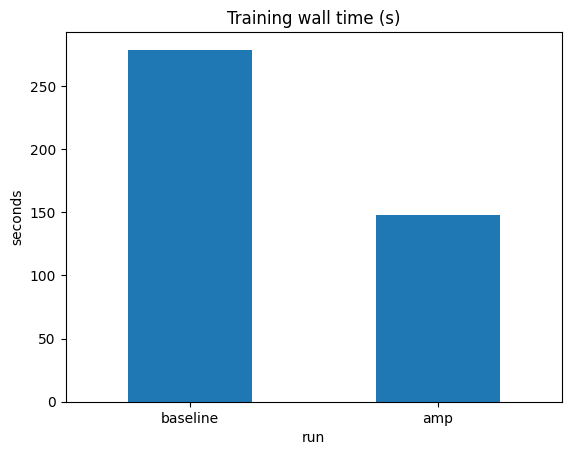

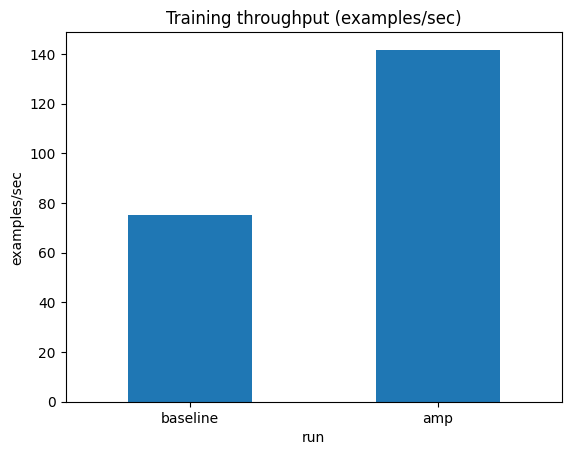

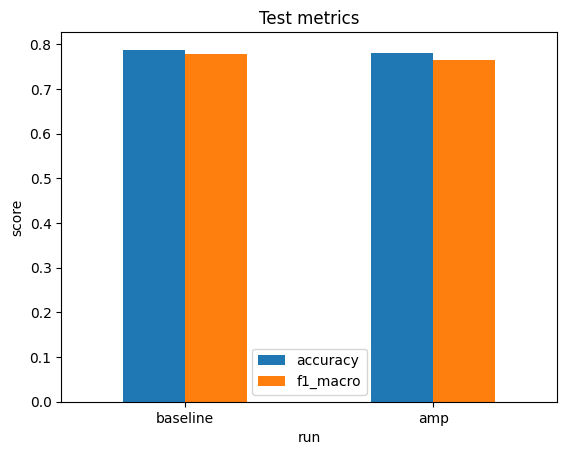


=== Inference summary ===


,variant,device,model_size_mb,eval_samples_per_s,accuracy,f1_macro,text_time_per_sentence_ms,eval_speedup_vs_baseline,compression_vs_baseline,text_latency_speedup_vs_baseline
0,amp_autocast,cuda:0,417.658215,1136.501850,0.787629,0.777792,8.452535,4.116758,1.000000,0.643269
1,baseline,cuda:0,417.658215,276.067228,0.787629,0.777792,5.437255,1.000000,1.000000,1.000000
2,fp16_weights,cuda:0,208.833014,572.834257,0.787629,0.777792,6.039699,2.074981,1.999963,0.900253


fp16_weights: Δaccuracy=+0.0000, Δf1_macro=+0.0000, eval_speedup=2.07x, compression=2.00x
amp_autocast: Δaccuracy=+0.0000, Δf1_macro=+0.0000, eval_speedup=4.12x, compression=1.00x


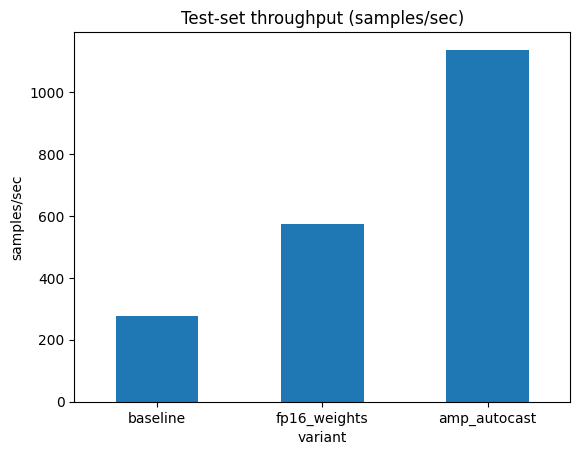

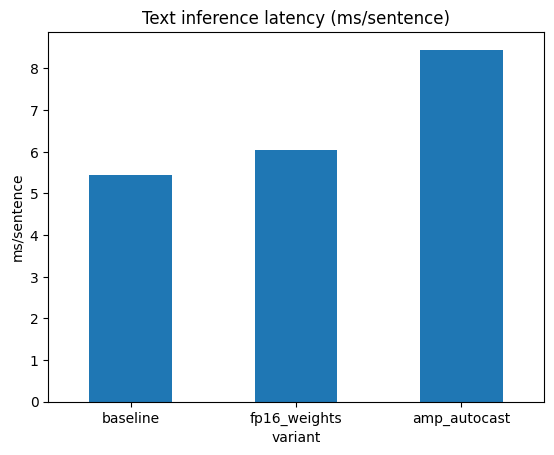

In [7]:
# =========================
# Results: tables + plots
# =========================

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)

print("\n=== Training summary ===")
if "train_summary_df" in globals() and not train_summary_df.empty:
    cols = [
        "run",
        "use_amp",
        "device",
        "train_wall_s",
        "train_examples_per_s",
        "accuracy",
        "f1_macro",
        "train_forward_pass_ms",
        "train_backward_pass_ms",
        "train_optimizer_step_ms",
    ]
    cols = [c for c in cols if c in train_summary_df.columns]
    display(train_summary_df[cols].sort_values("run"))

    if {"baseline", "amp"}.issubset(set(train_summary_df["run"])):
        base = train_summary_df[train_summary_df["run"] == "baseline"].iloc[0]
        amp = train_summary_df[train_summary_df["run"] == "amp"].iloc[0]
        print(
            f"Training speedup (baseline/amp): {base['train_wall_s'] / amp['train_wall_s']:.2f}x | "
            f"Δaccuracy (amp-baseline): {amp['accuracy'] - base['accuracy']:+.4f} | "
            f"Δf1_macro (amp-baseline): {amp['f1_macro'] - base['f1_macro']:+.4f}"
        )

    ax = train_summary_df.set_index("run")["train_wall_s"].plot(
        kind="bar", title="Training wall time (s)", rot=0
    )
    ax.set_ylabel("seconds")
    plt.show()

    ax = train_summary_df.set_index("run")["train_examples_per_s"].plot(
        kind="bar", title="Training throughput (examples/sec)", rot=0
    )
    ax.set_ylabel("examples/sec")
    plt.show()

    ax = train_summary_df.set_index("run")[["accuracy", "f1_macro"]].plot(
        kind="bar", title="Test metrics", rot=0
    )
    ax.set_ylabel("score")
    plt.show()
else:
    print("(no training runs executed)")


print("\n=== Inference summary ===")
if "inference_summary_df" in globals() and not inference_summary_df.empty:
    df = inference_summary_df.copy()

    if "baseline" in set(df["variant"]):
        base = df[df["variant"] == "baseline"].iloc[0]
        df["eval_speedup_vs_baseline"] = df["eval_samples_per_s"] / base["eval_samples_per_s"]
        df["compression_vs_baseline"] = base["model_size_mb"] / df["model_size_mb"]
        if "text_time_per_sentence_ms" in df.columns and base.get("text_time_per_sentence_ms"):
            df["text_latency_speedup_vs_baseline"] = (
                base["text_time_per_sentence_ms"] / df["text_time_per_sentence_ms"]
            )

    display(
        df[[
            "variant",
            "device",
            "model_size_mb",
            "eval_samples_per_s",
            "accuracy",
            "f1_macro",
            "text_time_per_sentence_ms",
            "eval_speedup_vs_baseline",
            "compression_vs_baseline",
            "text_latency_speedup_vs_baseline",
        ]]
        .sort_values("variant")
        .reset_index(drop=True)
    )

    if "baseline" in set(df["variant"]):
        base = df[df["variant"] == "baseline"].iloc[0]
        for _, row in df.iterrows():
            if row["variant"] == "baseline":
                continue
            print(
                f"{row['variant']}: Δaccuracy={row['accuracy'] - base['accuracy']:+.4f}, "
                f"Δf1_macro={row['f1_macro'] - base['f1_macro']:+.4f}, "
                f"eval_speedup={row.get('eval_speedup_vs_baseline', float('nan')):.2f}x, "
                f"compression={row.get('compression_vs_baseline', float('nan')):.2f}x"
            )

    ax = df.set_index("variant")["eval_samples_per_s"].plot(
        kind="bar", title="Test-set throughput (samples/sec)", rot=0
    )
    ax.set_ylabel("samples/sec")
    plt.show()

    if "text_time_per_sentence_ms" in df.columns:
        ax = df.set_index("variant")["text_time_per_sentence_ms"].plot(
            kind="bar", title="Text inference latency (ms/sentence)", rot=0
        )
        ax.set_ylabel("ms/sentence")
        plt.show()

else:
    print("(no inference benchmarks executed)")

